# IndoBERT Hate Speech

Hate Speech Detection System In Indonesian Language Using Indonesian Bidirectional Encoder Representations from Transformers (IndoBERT) Method

By Rizky Anugerah

# 1. Setup

## 1.1 Install Packages

Install packages so we can use the libraries that will be used

In [1]:
!pip install imbalanced-learn
!pip install transformers
!pip install nltk
!pip install PySastrawi
!pip install black[jupyter]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 32.3 MB/s 
     |████████████████████████████████| 6.6 MB 55.7 MB/s 
     |████████████████████████████████| 86 kB 6.8 MB/s 
     |████████████████████████████████| 596 kB 74.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 210 kB 8.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 11.9 MB/s 
     |█████

## 1.2 Import Libraries

Clone the IndoNLU repository first

In [2]:
# indonlu repository forked from https://github.com/indobenchmark/indonlu
!git clone https://github.com/ryzanugrah/indonlu

Cloning into 'indonlu'...
remote: Enumerating objects: 475, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 475 (delta 115), reused 112 (delta 112), pack-reused 331
Receiving objects: 100% (475/475), 4.84 MiB | 20.64 MiB/s, done.
Resolving deltas: 100% (241/241), done.


Then import the libraries

In [3]:
%%time

import os
import pickle
import random

from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import torch
import torch.nn.functional as F
from google.colab import data_table, drive
from indonlu.utils.data_utils import (
    HateSpeechClassificationDataLoader,
    MultiLabelHateSpeechClassificationDataset,
)
from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import multi_label_hate_speech_classification_metrics_fn
from sklearn.metrics import classification_report, confusion_matrix, precision_score, accuracy_score, recall_score, f1_score
from torch import optim
from tqdm import tqdm
from transformers import BertConfig, BertForSequenceClassification, BertTokenizer, AdamW
from transformers.optimization import Adafactor

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

CPU times: user 3.22 s, sys: 567 ms, total: 3.79 s
Wall time: 6.14 s


## 1.3 Colab Configuration
You can ignore this section if you are not using Google Colab

In [4]:
# mount Drive
drive.mount("/content/drive")

# enable data table display (interactive table)
data_table.enable_dataframe_formatter()

Mounted at /content/drive


## 1.4 Using GPU for Training


You can use GPUs to run this training code. 

> First, you'll need to enable GPUs for the notebook. GPUs can be added by going to the menu and selecting:

`Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 GPU`

Then run the following cell to confirm that the GPU is detected.

In [5]:
# check Tensorflow version
print('TensorFlow version: ' + tf.__version__)

# check PyTorch version
print('PyTorch version: ' + torch.__version__)

# get the GPU device name
device_name = tf.test.gpu_device_name()

# the device name should look like the following
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow version: 2.8.2
PyTorch version: 1.11.0+cu113
Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [6]:
# if there's a GPU available
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('GPU:', torch.cuda.get_device_name(0))

# if not
else:
    print('No GPU available.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
GPU: Tesla T4


## 1.5 Configuration

Set global variable, parameters, and hyperparameters used (Hyperparameter Tuning)

In [7]:
batch_size=32 # batch size
lr=2e-5 # learning rate
epochs=3 # epochs
attention_probs_dropout_prob=0.1 # dropout
hidden_dropout_prob=0.1 # dropout

max_seq_len=512 # maximum length
num_labels=4 # number of labels
num_workers=2 # number of workers // set lower for faster training
eps=1e-8 # epsilon
weight_decay=1e-2 #weight decay

random_state=0

## 1.6 Set Random Seed

In [8]:
# common functions
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
    
# count number of parameters  
def count_param(module, trainable=False):
  if trainable:
    return sum(p.numel() for p in module.parameters() if p.requires_grad)
  else:
    return sum(p.numel() for p in module.parameters())

# get the learning rate
def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

# change from metrics evaluation to string
def metrics_to_string(metric_dict):
  string_list = []
  
  for key, value in metric_dict.items():
    string_list.append('{}:{:.2f}'.format(key, value))
  return ' '.join(string_list)

# set the seed value all over the place to make this reproducible
set_seed(0)

# 2. Load Dataset

## 2.1 Import Dataset

In [9]:
# import dataset, forked dataset from (Ibrohim & Budi, 2019)
# raw data from 'https://raw.githubusercontent.com/okkyibrohim/id-multi-label-hate-speech-and-abusive-language-detection/master/re_dataset.csv'
df = "https://raw.githubusercontent.com/ryzanugrah/id-multi-label-hate-speech-and-abusive-language-detection/master/re_multi_label_dataset.csv"
df = pd.read_csv(df, encoding="utf-8")
df.rename({'Tweet': 'text'}, axis=1, inplace=True)

print('Dataset successfully imported')

Dataset successfully imported


In [10]:
# check how many records are in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13169 entries, 0 to 13168
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         13169 non-null  object
 1   HS           13169 non-null  int64 
 2   HS_Weak      13169 non-null  int64 
 3   HS_Moderate  13169 non-null  int64 
 4   HS_Strong    13169 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 514.5+ KB


In [11]:
# show the first 5 dataset rows
print("Number of Data: ", df.shape)
df.head()

Number of Data:  (13169, 5)


,text,HS,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,1,0,0,1
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,0,1,0


## 2.2 Show Data on Chart

### Histogram

1    7309
0    5860
Name: HS, dtype: int64

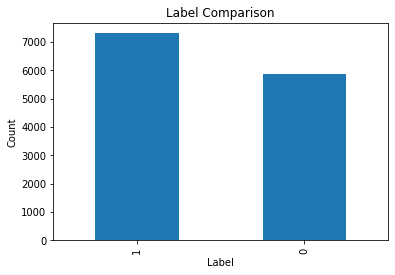

In [12]:
pd.value_counts(df["HS"]).plot.bar()
plt.title("Label Comparison")
plt.xlabel("Label")
plt.ylabel("Count")

# if you want to save this chart, uncomment line below
# plt.savefig('label_histogram', dpi=300)

df["HS"].value_counts()

### Donut Chart

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: float or None
  animated: bool
  antialiased or aa: unknown
  capstyle: {'butt', 'round', 'projecting'}
  center: unknown
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color: color
  contains: callable
  edgecolor or ec: color or None or 'auto'
  facecolor or fc: color or None
  figure: `.Figure`
  fill: bool
  gid: str
  hatch: {'/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*'}
  in_layout: bool
  joinstyle: {'miter', 'round', 'bevel'}
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float or None
  path_effects: `.AbstractPathEffect`
  picker: None or bool or float or callable
  radius: unknown
  rasterized: bool or None
  sketch_params: (scale: float, length: float, randomness: float)
  snap: bool or None
  theta1: unknown
  theta2: unknown
  transform: `.Transf

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.


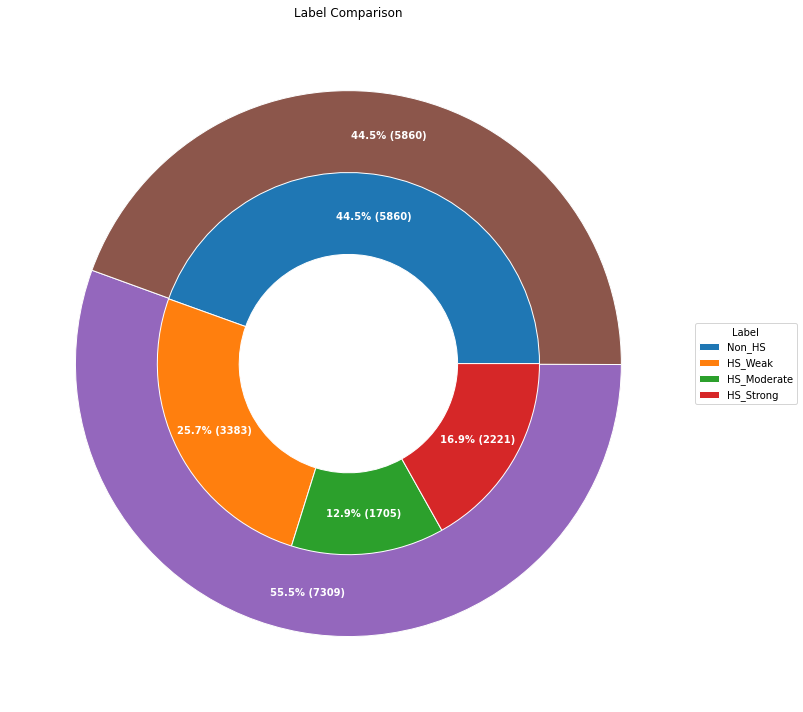

In [13]:
def show_pie(inner_label, outer_label, inner_df, outer_df, legend_title):
    fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(aspect="equal"))
    width = 0.3
    labels = [x.split()[-1] for x in inner_label]

    def func(pct, allvals):
        absolute = int(round(pct / 100.0 * np.sum(allvals)))
        return "{:.1f}% ({:d})".format(pct, absolute)

    # inner pie
    inner_pie = ax.pie(
        inner_df,
        autopct=lambda pct: func(pct, inner_df),
        textprops=dict(color="white", weight="bold"),
        pctdistance=0.55,
        wedgeprops={"width": 0.6, "edgecolor": "white"},
    )
    plt.setp(inner_pie)

    # outer pie
    outer_pie = ax.pie(
        outer_df,
        autopct=lambda pct: func(pct, outer_df),
        textprops=dict(color="white", weight="bold"),
        pctdistance=0.85,
        wedgeprops={"width": 0.3, "edgecolor": "white"},
        startangle=160,
    )
    plt.setp(outer_pie)

    # set legend label
    ax.legend(
        labels, title=legend_title, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1)
    )

    ax.set_title("Label Comparison")

    # show chart
    plt.tight_layout()
    plt.show()


# count value on each label
hs_label = df.HS.value_counts()
non_hs_label = df.loc[df.HS == 0, "HS"].count()
hs_weak_label = df.loc[df.HS_Weak == 1, "HS_Weak"].count()
hs_moderate_label = df.loc[df.HS_Moderate == 1, "HS_Moderate"].count()
hs_strong_label = df.loc[df.HS_Strong == 1, "HS_Strong"].count()

inner_label = ["Non_HS", "HS_Weak", "HS_Moderate", "HS_Strong"]
outer_label = ["HS", "Non_HS"]
count_inner_data = [non_hs_label, hs_weak_label, hs_moderate_label, hs_strong_label]
count_outer_data = [hs_label]

show_pie(inner_label, outer_label, count_inner_data, count_outer_data, "Label")

## 2.3 Import Slang Dictionary

In [14]:
# import kamus alay (indonesian slang words dictionary) from (Ibrohim & Budi, 2019)
alay_dict = "https://raw.githubusercontent.com/okkyibrohim/id-multi-label-hate-speech-and-abusive-language-detection/master/new_kamusalay.csv"
alay_dict = pd.read_csv(alay_dict, encoding="latin-1", header=None)
alay_dict = alay_dict.rename(columns={0: "original", 1: "replacement"})

print("Number of Data: ", alay_dict.shape)
alay_dict.head()

Number of Data:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali


# 3. Text Preprocessing

In [15]:
# Import raw dataset as a comparison
df_raw = "https://raw.githubusercontent.com/ryzanugrah/id-multi-label-hate-speech-and-abusive-language-detection/master/re_multi_label_dataset.csv"
df_raw = pd.read_csv(df_raw, encoding="utf-8")
df_raw.rename({'Tweet': 'raw_tweet'}, axis=1, inplace=True)

## 3.1 Data Cleaning

In [16]:
def data_cleaning(text):
    emoticon_byte_regex = r"\s*(?:\\x[A-Fa-f0-9]{2})+"
    url_regex = "((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+)||(http\S+))"

    text = re.sub(emoticon_byte_regex, "", text)  # remove emoticon bytes
    text = re.sub(url_regex, "", text)  # remove every url
    text = re.sub(r"<[^>]*>", "", text)  # remove html tags
    text = re.sub(r"@[A-Za-z0-9]+", "", text)  # remove twitter usernames
    text = re.sub(r"\\n", " ", text)  # remove every new line '\n'
    text = re.sub("@[\w\-]+", "", text)  # remove mentions
    text = re.sub("RT", "", text)  # remove every retweet symbol
    text = re.sub("USER", "", text)  # remove every user
    text = re.sub(" URL", " ", text)  # remove word URL
    text = re.sub(" url", " ", text)  # remove word url
    text = re.sub("\\+", " ", text)  # remove backslash
    text = re.sub("\s+", " ", text)  # remove special regular expression character
    text = re.sub("[^0-9a-zA-Z]", " ", text)  # remove punctuation
    text = re.sub("[^a-zA-Z]", " ", text)  # remove numbers
    text = re.sub(" +", " ", text)  # remove extra spaces

    return text


df["text"] = df["text"].apply(data_cleaning)
df.text = df.text.str.strip() # Removes any spaces or specified characters at the start and end of a string

df1 = df_raw[["raw_tweet"]]
df2 = df[["text"]]

df_compare = pd.concat([df1, df2], axis=1)
df_compare.head()

,raw_tweet,text
0,- disaat semua cowok berusaha melacak perhatia...,disaat semua cowok berusaha melacak perhatian ...
1,RT USER: USER siapa yang telat ngasih tau elu?...,siapa yang telat ngasih tau elu edan sarap gue...
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",Kadang aku berfikir kenapa aku tetap percaya p...
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,AKU ITU AKU KU TAU MATAMU SIPIT TAPI DILIAT DA...
4,USER USER Kaum cebong kapir udah keliatan dong...,Kaum cebong kapir udah keliatan dongoknya dari...


## 3.2 Case Folding

In [17]:
# lowercase letters
def case_folding(text):
    text = text.lower()
    return text


df["text"] = df["text"].apply(case_folding)

df1 = df_raw[["raw_tweet"]]
df2 = df[["text"]]

df_compare = pd.concat([df1, df2], axis=1)
df_compare.head()

,raw_tweet,text
0,- disaat semua cowok berusaha melacak perhatia...,disaat semua cowok berusaha melacak perhatian ...
1,RT USER: USER siapa yang telat ngasih tau elu?...,siapa yang telat ngasih tau elu edan sarap gue...
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",kadang aku berfikir kenapa aku tetap percaya p...
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,aku itu aku ku tau matamu sipit tapi diliat da...
4,USER USER Kaum cebong kapir udah keliatan dong...,kaum cebong kapir udah keliatan dongoknya dari...


## 3.3 Normalization

In [18]:
alay_dict_map = dict(zip(alay_dict["original"], alay_dict["replacement"]))


def normalize_alay_dict(text):
    return " ".join(
        [
            alay_dict_map[word] if word in alay_dict_map else word
            for word in text.split(" ")
        ]
    )


df["text"] = df["text"].apply(normalize_alay_dict)

df1 = df_raw[["raw_tweet"]]
df2 = df[["text"]]

df_compare = pd.concat([df1, df2], axis=1)
df_compare.head()

,raw_tweet,text
0,- disaat semua cowok berusaha melacak perhatia...,di saat semua cowok berusaha melacak perhatian...
1,RT USER: USER siapa yang telat ngasih tau elu?...,siapa yang telat memberi tau kamu edan sarap g...
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",kadang aku berpikir kenapa aku tetap percaya p...
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,aku itu aku ku tau matamu sipit tapi dilihat d...
4,USER USER Kaum cebong kapir udah keliatan dong...,kaum cebong kafir sudah kelihatan dongoknya da...


## 3.4 Filtering

In [19]:
# # Initiate (Tala, F. Z., 2003) stopword
# tala_stopword_dict = pd.read_csv(
#         "https://raw.githubusercontent.com/ryzanugrah/stopwords-id/master/stopwords-id.txt",
#         header=None,
#     )
# tala_stopword_dict = tala_stopword_dict.rename(columns={0: "stopword"})

# # Initiate NTLK stopword
# nltk.download("stopwords")
# nltk.download("punkt")

# def remove_stopword(text):
#     """Remove Stopword/Filtering."""

#     # Apply Stopword (Tala, F. Z., 2003)
#     text = " ".join(
#         [
#             "" if word in tala_stopword_dict.stopword.values else word
#             for word in text.split(" ")
#         ]
#     )

#     # Apply Stopword NLTK
#     nltk_stopword_dict = set(stopwords.words('indonesian'))
#     word_tokens = word_tokenize(text)
#     filtered_sentence = []
#     for word_token in word_tokens:
#         if word_token not in nltk_stopword_dict:
#             filtered_sentence.append(word_token)

#     text = " ".join(filtered_sentence) # Join words
#     text = re.sub("  +", " ", text)  # Remove extra spaces
#     text = text.strip() # Removes any spaces or specified characters at the start and end of a string

#     return text


# df["text"] = df["text"].apply(remove_stopword)

# df1 = df_raw[["raw_tweet"]]
# df2 = df[["text"]]

# df_compare = pd.concat([df1, df2], axis=1)
# df_compare.head()

## 3.5 Stemming

In [20]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()


def stemming(text):
    return stemmer.stem(text)


df["text"] = df["text"].apply(stemming)

df1 = df_raw[["raw_tweet"]]
df2 = df[["text"]]

df_compare = pd.concat([df1, df2], axis=1)
df_compare.head()

,raw_tweet,text
0,- disaat semua cowok berusaha melacak perhatia...,di saat semua cowok usaha lacak perhati gue ka...
1,RT USER: USER siapa yang telat ngasih tau elu?...,siapa yang telat beri tau kamu edan sarap gue ...
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",kadang aku pikir kenapa aku tetap percaya pada...
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,aku itu aku ku tau mata sipit tapi lihat dari ...
4,USER USER Kaum cebong kapir udah keliatan dong...,kaum cebong kafir sudah lihat dongok dari awal...


# 4. Index Classification

In [21]:
def label_classification_weak(hs):
    label = ""

    if int(hs) == 1:
        label = 1
    else:
        label = 0

    return label


def label_classification_moderate(hs):
    label = ""

    if int(hs) == 1:
        label = 2
    else:
        label = 0

    return label


def label_classification_strong(hs):
    label = ""

    if int(hs) == 1:
        label = 3
    else:
        label = 0

    return label


df["label_weak"] = df["HS_Weak"].apply(label_classification_weak)
df["label_moderate"] = df["HS_Moderate"].apply(label_classification_moderate)
df["label_strong"] = df["HS_Strong"].apply(label_classification_strong)

df["label"] = df[["label_weak", "label_moderate", "label_strong"]].max(1)
df = df[["text", "label"]]

df.to_csv("dataset_preprocessed.csv", index=False)

df.head()

,text,label
0,di saat semua cowok usaha lacak perhati gue ka...,1
1,siapa yang telat beri tau kamu edan sarap gue ...,3
2,kadang aku pikir kenapa aku tetap percaya pada...,0
3,aku itu aku ku tau mata sipit tapi lihat dari ...,0
4,kaum cebong kafir sudah lihat dongok dari awal...,2


In [22]:
print("Number of Data: ", df.shape)

# converting to df and assigning new name to the columns
value_counts = df["label"].value_counts()

df_value_counts = pd.DataFrame(value_counts)
df_value_counts = df_value_counts.reset_index()
df_value_counts.columns = ["label", "counts of label"]  # change columns name
df_value_counts

Number of Data:  (13169, 2)


,label,counts of label
0,0,5860
1,1,3383
2,3,2221
3,2,1705


# 5. Remove Missing Values

In [23]:
df_indexed = pd.read_csv("dataset_preprocessed.csv")
print(df_indexed.isnull().sum())

text     46
label     0
dtype: int64


In [24]:
df_indexed = df_indexed[df_indexed["text"].notna()]
print(df_indexed.isnull().sum())

text     0
label    0
dtype: int64


In [25]:
print("Number of Indexed Dataset: ", df_indexed.shape)

Number of Indexed Dataset:  (13123, 2)


In [26]:
# save dataset to Drive
df_indexed.to_csv("/content/drive/MyDrive/multi-label-hate-speech-detection/data/dataset_preprocessed.csv", index=False)
print('Preprocessed Dataset has been downloaded')

Preprocessed Dataset has been downloaded


# 6. Split Up Dataset

## 6.1 Import Preprocessed Dataset



In [27]:
# import preprocessed dataset
df = pd.read_csv("/content/drive/MyDrive/multi-label-hate-speech-detection/data/dataset_preprocessed.csv")
print('Dataset successfully imported')

Dataset successfully imported


In [28]:
print("Number of Data: ", df.shape)
df.head()

Number of Data:  (13123, 2)


,text,label
0,di saat semua cowok usaha lacak perhati gue ka...,1
1,siapa yang telat beri tau kamu edan sarap gue ...,3
2,kadang aku pikir kenapa aku tetap percaya pada...,0
3,aku itu aku ku tau mata sipit tapi lihat dari ...,0
4,kaum cebong kafir sudah lihat dongok dari awal...,2


## 6.2 Hold-out Validation

Split up dataset into train, valid, and test set with a ratio of 80% train, 10% test, and 10% valid

In [29]:
# define dataset
X = df["text"]
y = df["label"]

# split into 80:10:10 ration
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8, random_state=random_state)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_rem, y_rem, test_size=0.5, random_state=random_state
)

# describe info about train, valid, and test set
print("Number of Train Dataset: ", y_train.shape)
print(y_train.value_counts())

print("\nNumber of Valid Dataset: ", y_valid.shape)
print(y_valid.value_counts())

print("\nNumber of Test Dataset: ", y_test.shape)
print(y_test.value_counts())

df_train = pd.concat([X_train, y_train], axis=1)
df_valid = pd.concat([X_valid, y_valid], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

df_train.to_csv("dataset_training.csv", index=False)
df_valid.to_csv("dataset_validation.csv", index=False)
df_test.to_csv("dataset_testing.csv", index=False)

Number of Train Dataset:  (10498,)
0    4668
1    2672
3    1810
2    1348
Name: label, dtype: int64

Number of Valid Dataset:  (1312,)
0    560
1    372
3    201
2    179
Name: label, dtype: int64

Number of Test Dataset:  (1313,)
0    594
1    332
3    210
2    177
Name: label, dtype: int64


In [30]:
df_train = pd.read_csv("dataset_training.csv")
df_test = pd.read_csv("dataset_testing.csv")
df_valid = pd.read_csv("dataset_validation.csv")

## 6.3 Balancing Data with SMOTE (Optional)
Uncomment this section if you want to work with balance data

In [31]:
# # convert strings into numericals using TfidfVectorizer
# vec_train = TfidfVectorizer()
# vec_test = TfidfVectorizer()
# vec_valid = TfidfVectorizer()

# X_train = vec_train.fit_transform(df_train['text'])
# X_valid = vec_valid.fit_transform(df_valid['text'])
# X_test = vec_test.fit_transform(df_test['text'])

In [32]:
# sm = SMOTE(random_state = 42)

# X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())
# X_test_res, y_test_res = sm.fit_resample(X_test, y_test.ravel())
# X_valid_res, y_valid_res = sm.fit_resample(X_valid, y_valid.ravel())

# # convert back into strings using inverse_transform
# X_train_res = vec_train.inverse_transform(X_train_res)
# X_test_res = vec_test.inverse_transform(X_test_res)
# X_valid_res = vec_valid.inverse_transform(X_valid_res)

# pd.DataFrame({'text': X_train_res}).to_csv("X_train.csv", index=False)
# pd.DataFrame({'label': y_train_res}).to_csv("y_train.csv", index=False)

# pd.DataFrame({'text': X_test_res}).to_csv("X_test.csv", index=False)
# pd.DataFrame({'label': y_test_res}).to_csv("y_test.csv", index=False)

# pd.DataFrame({'text': X_valid_res}).to_csv("X_valid.csv", index=False)
# pd.DataFrame({'label': y_valid_res}).to_csv("y_valid.csv", index=False)

In [33]:
# print("Before OverSampling, counts of label '0': {}".format(sum(y_train == 0)))
# print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
# print("Before OverSampling, counts of label '2': {}".format(sum(y_train == 2)))
# print("Before OverSampling, counts of label '3': {} \n".format(sum(y_train == 3)))

# print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

# print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))
# print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
# print("After OverSampling, counts of label '2': {}".format(sum(y_train_res == 2)))
# print("After OverSampling, counts of label '3': {}".format(sum(y_train_res == 3)))

In [34]:
# print("Before OverSampling, counts of label '0': {}".format(sum(y_valid == 0)))
# print("Before OverSampling, counts of label '1': {}".format(sum(y_valid == 1)))
# print("Before OverSampling, counts of label '2': {}".format(sum(y_valid == 2)))
# print("Before OverSampling, counts of label '3': {} \n".format(sum(y_valid == 3)))

# print('After OverSampling, the shape of valid_y: {} \n'.format(y_valid_res.shape))

# print("After OverSampling, counts of label '0': {}".format(sum(y_valid_res == 0)))
# print("After OverSampling, counts of label '1': {}".format(sum(y_valid_res == 1)))
# print("After OverSampling, counts of label '2': {}".format(sum(y_valid_res == 2)))
# print("After OverSampling, counts of label '3': {}".format(sum(y_valid_res == 3)))

In [35]:
# print("Before OverSampling, counts of label '0': {}".format(sum(y_test == 0)))
# print("Before OverSampling, counts of label '1': {}".format(sum(y_test == 1)))
# print("Before OverSampling, counts of label '2': {}".format(sum(y_test == 2)))
# print("Before OverSampling, counts of label '3': {} \n".format(sum(y_test == 3)))

# print('After OverSampling, the shape of test_y: {} \n'.format(y_test_res.shape))

# print("After OverSampling, counts of label '0': {}".format(sum(y_test_res == 0)))
# print("After OverSampling, counts of label '1': {}".format(sum(y_test_res == 1)))
# print("After OverSampling, counts of label '2': {}".format(sum(y_test_res == 2)))
# print("After OverSampling, counts of label '3': {}".format(sum(y_test_res == 3)))

In [36]:
# def data_cleaning(text):
#   text = re.sub("['']", "", text)
#   text = text.replace('[', '').replace(']', '')
#   return text

# df_train = pd.read_csv('X_train.csv')
# df_test = pd.read_csv('X_test.csv')
# df_valid = pd.read_csv('X_valid.csv')

# df_train["text"] = df_train["text"].apply(data_cleaning)
# df_train.text = df_train.text.str.strip()

# df_test["text"] = df_test["text"].apply(data_cleaning)
# df_test.text = df_test.text.str.strip()

# df_valid["text"] = df_valid["text"].apply(data_cleaning)
# df_valid.text = df_valid.text.str.strip()

In [37]:
# df_train[["text"]].head()

In [38]:
# df_test[["text"]].head()

In [39]:
# df_valid[["text"]].head()

In [40]:
# df_train.to_csv("X_train.csv", index=False)
# df_test.to_csv("X_test.csv", index=False)
# df_valid.to_csv("X_valid.csv", index=False)

In [41]:
# # save temp data training
# df_X_train = pd.read_csv('X_train.csv')
# df_y_train = pd.read_csv('y_train.csv')

# df_train = pd.concat([df_X_train, df_y_train], axis=1)

In [42]:
# # save temp data validation
# df_X_valid = pd.read_csv('X_valid.csv')
# df_y_valid = pd.read_csv('y_valid.csv')

# df_valid = pd.concat([df_X_valid, df_y_valid], axis=1)

In [43]:
# # save temp data testing
# df_X_test = pd.read_csv('X_test.csv')
# df_y_test = pd.read_csv('y_test.csv')

# df_test = pd.concat([df_X_test, df_y_test], axis=1)

## 6.4 Label Classification

In [44]:
def label_classification(hs):
    label = ""

    if int(hs) == 1:
        label = "HS_Weak"
    elif int(hs) == 2:
        label = "HS_Moderate"
    elif int(hs) == 3:
        label = "HS_Strong"
    else:
        label = "Non_HS"

    return label


df_train["label"] = df_train["label"].apply(label_classification)

df_train = df_train[["text", "label"]]

df_train.to_csv("dataset_training.csv", index=False)

df_train.head()

,text,label
0,pakai emot emot saja gih emot nete contoh,HS_Strong
1,dalam kancah politik alir saja sebut bagai bud...,Non_HS
2,ya allah sinyal axis geblek banget sudah,HS_Moderate
3,banyak cina yang pilih jokowi jadi aku pilih b...,Non_HS
4,hujan goda itu ojek pengkol mau juga ngerojok ...,HS_Strong


In [45]:
def label_classification(hs):
    label = ""

    if int(hs) == 1:
        label = "HS_Weak"
    elif int(hs) == 2:
        label = "HS_Moderate"
    elif int(hs) == 3:
        label = "HS_Strong"
    else:
        label = "Non_HS"

    return label


df_test["label"] = df_test["label"].apply(label_classification)

df_test = df_test[["text", "label"]]

df_test.to_csv("dataset_testing.csv", index=False)

df_test.head()

,text,label
0,apa huhungannya bego sama lesbi anjir,HS_Strong
1,tak tau deh mimpi doang kayak sudah lupa gue c...,Non_HS
2,percaya sama pakar dari pada allah it musyrik ...,Non_HS
3,yang sebab agama cacat adalah hawa nafsu hari ...,Non_HS
4,soal produk asing yang lewat tolong buka lagi ...,Non_HS


In [46]:
def label_classification(hs):
    label = ""

    if int(hs) == 1:
        label = "HS_Weak"
    elif int(hs) == 2:
        label = "HS_Moderate"
    elif int(hs) == 3:
        label = "HS_Strong"
    else:
        label = "Non_HS"

    return label


df_valid["label"] = df_valid["label"].apply(label_classification)

df_valid = df_valid[["text", "label"]]

df_valid.to_csv("dataset_validation.csv", index=False)

df_valid.head()

,text,label
0,kata airlangga pribadi jangan lupa bu khofifah...,Non_HS
1,berengsek banget yang kirim foto setan,HS_Weak
2,betapa biadab teroris buddha myanmar ini,HS_Moderate
3,kalau aku jual amik untung teruk x ganda aku c...,Non_HS
4,pada sabtu pagi masyarakat adat badui akan kem...,Non_HS


## 6.5 Remove Missing Values

Remove missing value if any, just for make sure once again.

In [47]:
df_train = pd.read_csv("dataset_training.csv")
print(df_train.isnull().sum())

text     0
label    0
dtype: int64


In [48]:
df_test = pd.read_csv("dataset_testing.csv")
print(df_test.isnull().sum())

text     0
label    0
dtype: int64


In [49]:
df_valid = pd.read_csv("dataset_validation.csv")
print(df_valid.isnull().sum())

text     0
label    0
dtype: int64


In [50]:
df_train = df_train[df_train["text"].notna()]
print(df_train.isnull().sum())

text     0
label    0
dtype: int64


In [51]:
df_test = df_test[df_test["text"].notna()]
print(df_test.isnull().sum())

text     0
label    0
dtype: int64


In [52]:
df_valid = df_valid[df_valid["text"].notna()]
print(df_valid.isnull().sum())

text     0
label    0
dtype: int64


In [53]:
print("Number of Data Training: ", df_train.shape)
print("Number of Data Testing: ", df_test.shape)
print("Number of Data Validation: ", df_valid.shape)

Number of Data Training:  (10498, 2)
Number of Data Testing:  (1313, 2)
Number of Data Validation:  (1312, 2)


In [54]:
# save split up dataset to Drive
df_train.to_csv("/content/drive/MyDrive/multi-label-hate-speech-detection/data/dataset_training.csv", index=False)
df_test.to_csv("/content/drive/MyDrive/multi-label-hate-speech-detection/data/dataset_testing.csv", index=False)
df_valid.to_csv("/content/drive/MyDrive/multi-label-hate-speech-detection/data/dataset_validation.csv", index=False)
print('Dataset has been downloaded')

Dataset has been downloaded


# 7. Modeling Pretrained Model

## 7.1 Tokenizing & Embedding

In [55]:
%%time

# load tokenizer
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

# load config
print('Loading BERT config...')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1', attention_probs_dropout_prob=attention_probs_dropout_prob, hidden_dropout_prob=hidden_dropout_prob, num_labels=num_labels)
config.num_labels = MultiLabelHateSpeechClassificationDataset.NUM_LABELS

# instantiate model
print('Instantiate BERT model...')
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

# tell pytorch to run this model on the GPU
model.cuda()

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

Loading BERT config...
Instantiate BERT model...


Downloading:   0%|          | 0.00/475M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CPU times: user 8.69 s, sys: 1.63 s, total: 10.3 s
Wall time: 10.8 s


In [56]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (50000, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [57]:
config

BertConfig {
  "_name_or_path": "indobenchmark/indobert-base-p1",
  "_num_labels": 5,
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.0",
  "type_vocab_size": 2,


In [58]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [59]:
count_param(model)

124444420

Apply the tokenizer to one sentence just to see the output.

In [60]:
text_1 = "kebahagiaan terbesarku adalah melihatmu bersama dengan dirinya"
text_2 = "dengan begitu kau akan tenang bersamanya"

text = (text_1, text_2)

text = " ".join(text)

token = tokenizer.tokenize(text) # tokenizing
encoding = tokenizer.encode(text_1, text_2) # token ids
decoding = tokenizer.decode(encoding) # token embeddings
encoding_input = tokenizer(text)

print('Text: ', text)
print('Tokenized: ', token)
print('Token Embeddings: ',decoding)
print('Token IDs: ', encoding_input)

Text:  kebahagiaan terbesarku adalah melihatmu bersama dengan dirinya dengan begitu kau akan tenang bersamanya
Tokenized:  ['kebahagiaan', 'terbesar', '##ku', 'adalah', 'melihatmu', 'bersama', 'dengan', 'dirinya', 'dengan', 'begitu', 'kau', 'akan', 'tenang', 'bersamanya']
Token Embeddings:  [CLS] kebahagiaan terbesarku adalah melihatmu bersama dengan dirinya [SEP] dengan begitu kau akan tenang bersamanya [SEP]
Token IDs:  {'input_ids': [2, 7139, 2805, 457, 154, 23670, 943, 79, 1702, 79, 975, 954, 150, 4134, 16636, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


## 7.2 Create DataLoader

Create an iterator for dataset using Torch's DataLoader class. This helps save memory during training and don't have to load the entire dataset into memory.

In [61]:
training_dataset_path = '/content/drive/MyDrive/multi-label-hate-speech-detection/data/dataset_training.csv'
validation_dataset_path = '/content/drive/MyDrive/multi-label-hate-speech-detection/data/dataset_validation.csv'
testing_dataset_path = '/content/drive/MyDrive/multi-label-hate-speech-detection/data/dataset_testing.csv'

In [62]:
training_dataset = MultiLabelHateSpeechClassificationDataset(training_dataset_path, tokenizer, lowercase=True)
validation_dataset = MultiLabelHateSpeechClassificationDataset(validation_dataset_path, tokenizer, lowercase=True)
testing_dataset = MultiLabelHateSpeechClassificationDataset(testing_dataset_path, tokenizer, lowercase=True)

In [63]:
training_loader = HateSpeechClassificationDataLoader(dataset=training_dataset, max_seq_len=max_seq_len, batch_size=batch_size, num_workers=num_workers, shuffle=True)  
validation_loader = HateSpeechClassificationDataLoader(dataset=validation_dataset, max_seq_len=max_seq_len, batch_size=batch_size, num_workers=num_workers, shuffle=False)  
testing_loader = HateSpeechClassificationDataLoader(dataset=testing_dataset, max_seq_len=max_seq_len, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [64]:
len(training_dataset), len(validation_dataset), len(testing_dataset)

(10498, 1312, 1313)

In [65]:
len(training_loader), len(validation_loader), len(testing_loader)

(329, 41, 42)

Labeling the index and vice versa

In [66]:
w2i, i2w = MultiLabelHateSpeechClassificationDataset.LABEL2INDEX, MultiLabelHateSpeechClassificationDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'Non_HS': 0, 'HS_Weak': 1, 'HS_Moderate': 2, 'HS_Strong': 3}
{0: 'Non_HS', 1: 'HS_Weak', 2: 'HS_Moderate', 3: 'HS_Strong'}


## 7.3 Classification only with IndoBERT pre-trained model

In [67]:
text = 'kebahagiaan terbesarku adalah melihatmu bersama dengan dirinya'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text}')
print(f'Label: {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: kebahagiaan terbesarku adalah melihatmu bersama dengan dirinya
Label: HS_Weak (30.646%)


In [68]:
text = 'tukang bully mati aja sana'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text}')
print(f'Label: {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: tukang bully mati aja sana
Label: HS_Strong (40.122%)


In [69]:
text = 'antek antek komunis mati sana'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text}')
print(f'Label: {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: antek antek komunis mati sana
Label: HS_Strong (38.116%)


In [70]:
text = 'kemaren gue ga di ajak tai emang'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text}')
print(f'Label: {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: kemaren gue ga di ajak tai emang
Label: HS_Strong (36.776%)


## 7.4 Fine Tuning

Now the input data is properly formatted, it's time to fine tune the BERT model. 

In [71]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=eps, weight_decay=weight_decay)
model = model.cuda()

This training code is based on the `run_glue.py` script here:
https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

In [72]:
%%time

train_acc_lists = []
train_pre_lists = []
train_rec_lists = []
train_f1_lists = []

eval_acc_lists = []
eval_pre_lists = []
eval_rec_lists = []
eval_f1_lists = []

train_loss_lists = []
eval_loss_lists = []
 
# fine tuning
for epoch in range(0, epochs):

  # ========================================
  #               Training
  # ========================================

  model.train()
  torch.set_grad_enabled(True)
 
  # reset the total loss for this epoch
  total_train_loss = 0

  list_hyp, list_label = [], []

  train_pbar = tqdm(training_loader, leave=True, total=len(training_loader))
  for i, batch_data in enumerate(train_pbar):
    # forward model
    loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

    # update model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    tr_loss = loss.item()
    total_train_loss = total_train_loss + tr_loss

    # calculate metrics
    list_hyp += batch_hyp
    list_label += batch_label

    train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
      total_train_loss/(i+1), get_lr(optimizer)))

  # calculate train metric
  metrics = multi_label_hate_speech_classification_metrics_fn(list_hyp, list_label)
  print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
      total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))
  
  train_acc_lists.append(metrics['ACC'])
  train_pre_lists.append(metrics['PRE'])
  train_rec_lists.append(metrics['REC'])
  train_f1_lists.append(metrics['F1'])
  current_train_loss = round(total_train_loss/(i+1), 4)
  train_loss_lists.append(current_train_loss)

  # ========================================
  #               Validation
  # ========================================
  # After the completion of each training epoch, measure our performance on
  # our validation set.

  model.eval()
  torch.set_grad_enabled(False)
    
  total_loss, total_correct, total_labels = 0, 0, 0
  list_hyp, list_label = [], []

  pbar = tqdm(validation_loader, leave=True, total=len(validation_loader))
  
  for i, batch_data in enumerate(pbar):
    batch_seq = batch_data[-1]        
    loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        
    # calculate total loss
    valid_loss = loss.item()
    total_loss = total_loss + valid_loss

    # calculate evaluation metrics
    list_hyp += batch_hyp
    list_label += batch_label
    metrics = multi_label_hate_speech_classification_metrics_fn(list_hyp, list_label)

    pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))
        
  metrics = multi_label_hate_speech_classification_metrics_fn(list_hyp, list_label)
  print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
    total_loss/(i+1), metrics_to_string(metrics)))
  
  eval_acc_lists.append(metrics['ACC'])
  eval_pre_lists.append(metrics['PRE'])
  eval_rec_lists.append(metrics['REC'])
  eval_f1_lists.append(metrics['F1'])
  current_eval_loss = round(total_loss/(i+1), 4)
  eval_loss_lists.append(current_eval_loss) 

(Epoch 1) TRAIN LOSS:0.7711 LR:0.00002000: 100%|██████████| 329/329 [01:37<00:00,  3.36it/s]


(Epoch 1) TRAIN LOSS:0.7711 ACC:0.69 F1:0.62 REC:0.61 PRE:0.64 LR:0.00002000


VALID LOSS:0.6633 ACC:0.74 F1:0.70 REC:0.72 PRE:0.70: 100%|██████████| 41/41 [00:04<00:00,  9.31it/s]


(Epoch 1) VALID LOSS:0.6633 ACC:0.74 F1:0.70 REC:0.72 PRE:0.70


(Epoch 2) TRAIN LOSS:0.4665 LR:0.00002000: 100%|██████████| 329/329 [01:38<00:00,  3.33it/s]


(Epoch 2) TRAIN LOSS:0.4665 ACC:0.83 F1:0.78 REC:0.78 PRE:0.79 LR:0.00002000


VALID LOSS:0.6409 ACC:0.77 F1:0.73 REC:0.73 PRE:0.74: 100%|██████████| 41/41 [00:04<00:00,  9.29it/s]


(Epoch 2) VALID LOSS:0.6409 ACC:0.77 F1:0.73 REC:0.73 PRE:0.74


(Epoch 3) TRAIN LOSS:0.2956 LR:0.00002000: 100%|██████████| 329/329 [01:38<00:00,  3.33it/s]


(Epoch 3) TRAIN LOSS:0.2956 ACC:0.89 F1:0.86 REC:0.86 PRE:0.87 LR:0.00002000


VALID LOSS:0.6842 ACC:0.78 F1:0.74 REC:0.75 PRE:0.74: 100%|██████████| 41/41 [00:04<00:00,  9.31it/s]

(Epoch 3) VALID LOSS:0.6842 ACC:0.78 F1:0.74 REC:0.75 PRE:0.74
CPU times: user 3min 31s, sys: 1min 30s, total: 5min 1s
Wall time: 5min 9s


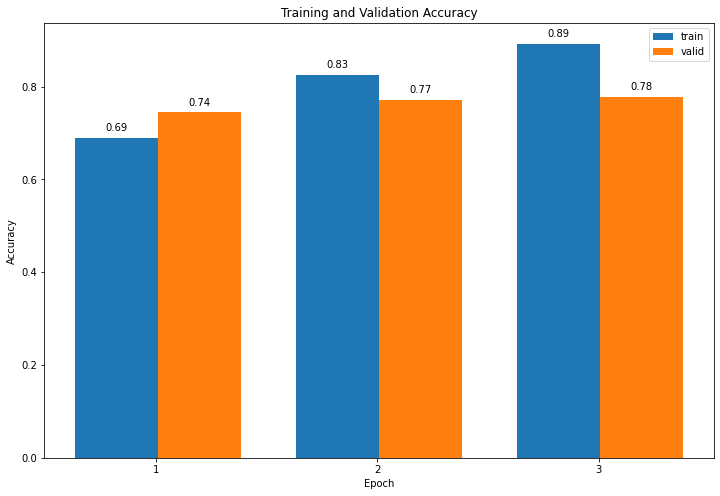

In [73]:
%matplotlib inline

epoch = [1,2,3,4]
width = 0.25

# Show accuracy bar plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set position of bar on X axis
br1 = np.arange(len(train_acc_lists))/1.5
br2 = [x + width for x in br1]

plt.bar(br1, train_acc_lists, label='train', width=width)
plt.bar(br2, eval_acc_lists, label='valid', width=width)

# Annotate
for p in ax.patches:
    ax.annotate(
        np.round(p.get_height(), decimals=2),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
    )

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.xticks([r/1.5-0.13 + width for r in range(len(train_acc_lists))], epoch)
plt.legend()

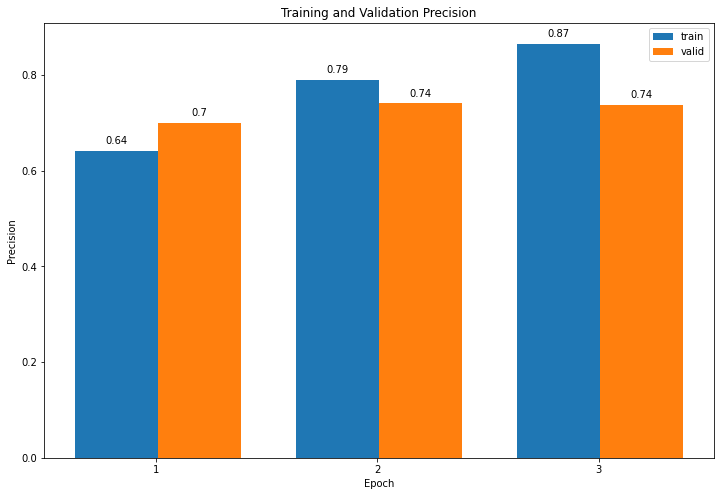

In [74]:
%matplotlib inline

# Show precision bar plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set position of bar on X axis
br1 = np.arange(len(train_pre_lists))/1.5
br2 = [x + width for x in br1]

plt.bar(br1, train_pre_lists, label='train', width=width)
plt.bar(br2, eval_pre_lists, label='valid', width=width)

# Annotate
for p in ax.patches:
    ax.annotate(
        np.round(p.get_height(), decimals=2),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
    )

plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training and Validation Precision')
plt.xticks([r/1.5-0.13 + width for r in range(len(train_pre_lists))], epoch)
plt.legend()

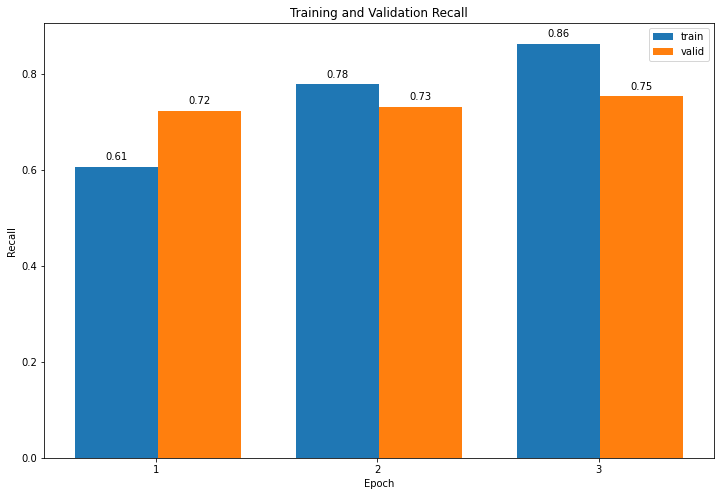

In [75]:
%matplotlib inline

# Show recall bar plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set position of bar on X axis
br1 = np.arange(len(train_rec_lists))/1.5
br2 = [x + width for x in br1]

plt.bar(br1, train_rec_lists, label='train', width=width)
plt.bar(br2, eval_rec_lists, label='valid', width=width)

# Annotate
for p in ax.patches:
    ax.annotate(
        np.round(p.get_height(), decimals=2),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
    )

plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Training and Validation Recall')
plt.xticks([r/1.5-0.13 + width for r in range(len(train_rec_lists))], epoch)
plt.legend()

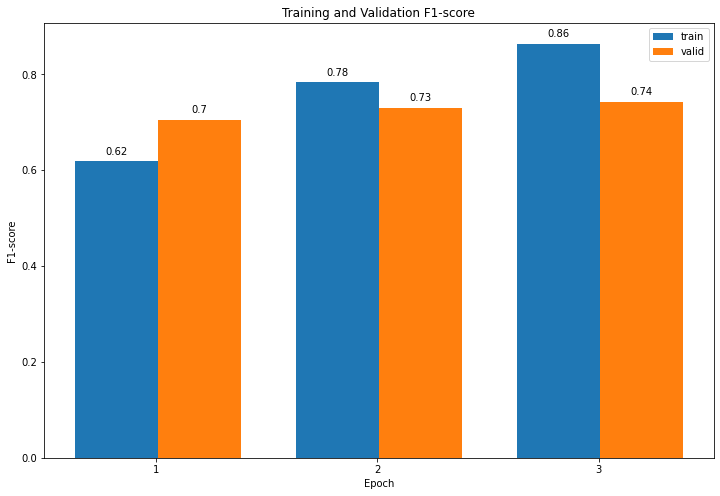

In [76]:
%matplotlib inline

# Show f1-score bar plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set position of bar on X axis
br1 = np.arange(len(train_f1_lists))/1.5
br2 = [x + width for x in br1]

plt.bar(br1, train_f1_lists, label='train', width=width)
plt.bar(br2, eval_f1_lists, label='valid', width=width)

# Annotate
for p in ax.patches:
    ax.annotate(
        np.round(p.get_height(), decimals=2),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
    )

plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.title('Training and Validation F1-score')
plt.xticks([r/1.5-0.13 + width for r in range(len(train_f1_lists))], epoch)
plt.legend()

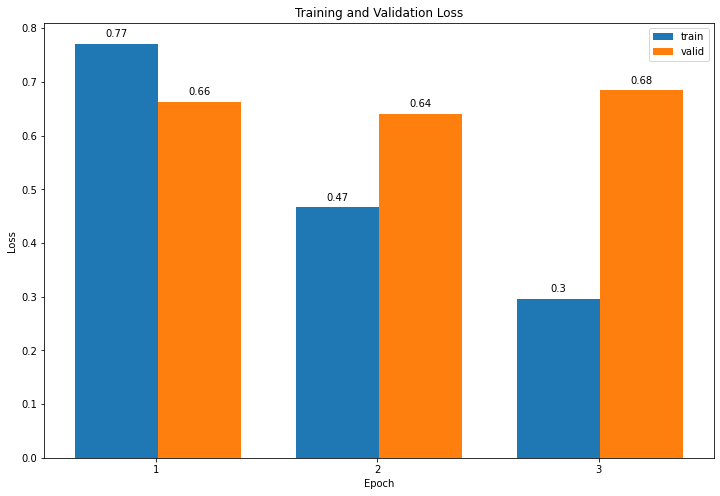

In [77]:
%matplotlib inline

# Show loss bar plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set position of bar on X axis
br1 = np.arange(len(train_loss_lists))/1.5
br2 = [x + width for x in br1]

plt.bar(br1, train_loss_lists, label='train', width=width)
plt.bar(br2, eval_loss_lists, label='valid', width=width)

# Annotate
for p in ax.patches:
    ax.annotate(
        np.round(p.get_height(), decimals=2),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
    )

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.xticks([r/1.5-0.13 + width for r in range(len(train_loss_lists))], epoch)
plt.legend()

In [78]:
# constructing dataframe from training
df_stats = {'Train Accuracy': np.round(train_acc_lists, 2), 'Train Precision': np.round(train_pre_lists,2), 'Train Recall': np.round(train_rec_lists,2), 'Train F1': np.round(train_f1_lists,2), 'Valid Accuracy': np.round(eval_acc_lists,2), 'Valid Precision': np.round(eval_pre_lists,2), 'Valid Recall': np.round(eval_rec_lists,2), 'Valid F1': np.round(eval_f1_lists,2), 'Train Loss': np.round(train_loss_lists,2), 'Valid Loss': np.round(eval_loss_lists,2)}

# create a dataframe from training
df_stats = pd.DataFrame(data=df_stats)

# rename row index as 'Epoch'
df_stats = df_stats.rename_axis('Epoch')

# display the table
df_stats.index = df_stats.index + 1
df_stats

,Train Accuracy,Train Precision,Train Recall,Train F1,Valid Accuracy,Valid Precision,Valid Recall,Valid F1,Train Loss,Valid Loss
Epoch,,,,,,,,,,
1,0.69,0.64,0.61,0.62,0.74,0.70,0.72,0.70,0.77,0.66
2,0.83,0.79,0.78,0.78,0.77,0.74,0.73,0.73,0.47,0.64
3,0.89,0.87,0.86,0.86,0.78,0.74,0.75,0.74,0.30,0.68


# 8. Evaluation

## 8.1 Evaluate on Test Set

With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [79]:
%%time

# put model in evaluation mode
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

print('Loading Testing DataLoader...')

pbar = tqdm(testing_loader, leave=True, total=len(testing_loader))
for i, batch_data in enumerate(pbar):
  _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
  list_hyp += batch_hyp

df = pd.DataFrame({'label':list_hyp}).reset_index()
df.to_csv('prediction.txt', index=False)

print(df)

Loading Testing DataLoader...


100%|██████████| 42/42 [00:04<00:00,  9.81it/s]

      index        label
0         0    HS_Strong
1         1       Non_HS
2         2       Non_HS
3         3       Non_HS
4         4      HS_Weak
...     ...          ...
1308   1308  HS_Moderate
1309   1309       Non_HS
1310   1310    HS_Strong
1311   1311  HS_Moderate
1312   1312  HS_Moderate

[1313 rows x 2 columns]
CPU times: user 3.98 s, sys: 114 ms, total: 4.1 s
Wall time: 4.3 s


In [80]:
prediction = pd.read_csv('prediction.txt')

In [81]:
prediction_list = []

for i in prediction['label'] : 
  if i == 'HS_Weak': 
    prediction_list.append(1)
  elif i == 'HS_Moderate': 
    prediction_list.append(2)
  elif i == 'HS_Strong': 
    prediction_list.append(3)
  else :
    prediction_list.append(0)

In [82]:
data_test = pd.read_csv('/content/drive/MyDrive/multi-label-hate-speech-detection/data/dataset_testing.csv')

def label_classification(hs):
  label = ''
  
  if str(hs) == 'HS_Weak':
    label = 1
  elif str(hs) == 'HS_Moderate':
    label = 2
  elif str(hs) == 'HS_Strong':
    label = 3
  else:
    label = 0

  return label

data_test['label'] = data_test['label'].apply(label_classification)

data_test = data_test[['text', 'label']]

data_test.head().style.hide_index()

text,label
apa huhungannya bego sama lesbi anjir,3
tak tau deh mimpi doang kayak sudah lupa gue cuma bagi ketemu kunti banyak nya itu yang ingat,0
percaya sama pakar dari pada allah it musyrik percaya sih boleh saja tetapi jangan lebih sampai lost respect,0
yang sebab agama cacat adalah hawa nafsu hari asy shihab,0
soal produk asing yang lewat tolong buka lagi sejarah islam lebih dulu masuk ke cina ketimbang nusantara baju koko takwa itu asli dari cina bukan budaya kita dan jubah yang kamu pakai budaya impor dari arab jadi tolong lebih baik anda telanjang saja biar ucap bisa sesi,0


In [83]:
print(f"Accuracy: {round(accuracy_score(data_test['label'], prediction_list), 2)}") 
print(f"Precision: {round(precision_score(data_test['label'], prediction_list, average='macro'), 2)}")
print(f"Recall: {round(recall_score(data_test['label'], prediction_list, average='macro'), 2)}")

Accuracy: 0.79
Precision: 0.75
Recall: 0.76


In [84]:
# micro avg of f1-score
f1_score_micro = f1_score(data_test['label'], prediction_list, average='micro') * 100
print("F1-score (Micro Avg) is {}%." .format(round(f1_score_micro),1))

# macro avg of f1-score
f1_score_macro = f1_score(data_test['label'], prediction_list, average='macro') * 100
print("F1-score (Macro Avg) is {}%." .format(round(f1_score_macro),1))

# weighted avg of f1-score
f1_score_weighted = f1_score(data_test['label'], prediction_list, average='weighted') * 100
print("F1-score (Weighted Avg) is {}%." .format(round(f1_score_weighted),1))

F1-score (Micro Avg) is 79%.
F1-score (Macro Avg) is 76%.
F1-score (Weighted Avg) is 79%.


In [85]:
print("Classification Report:")
print(classification_report(data_test['label'], prediction_list))

report = classification_report(data_test["label"], prediction_list, output_dict=True)
report = pd.DataFrame(report).round(2).transpose()
print("Classification Report Table:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       594
           1       0.77      0.68      0.72       332
           2       0.64      0.71      0.67       177
           3       0.71      0.78      0.75       210

    accuracy                           0.79      1313
   macro avg       0.75      0.76      0.76      1313
weighted avg       0.80      0.79      0.79      1313

Classification Report Table:
              precision  recall  f1-score  support
0                  0.89    0.89      0.89   594.00
1                  0.77    0.68      0.72   332.00
2                  0.64    0.71      0.67   177.00
3                  0.71    0.78      0.75   210.00
accuracy           0.79    0.79      0.79     0.79
macro avg          0.75    0.76      0.76  1313.00
weighted avg       0.80    0.79      0.79  1313.00


Confusion Matrix:


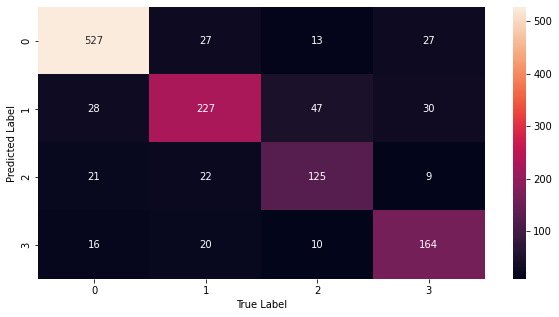

In [86]:
print("Confusion Matrix:")
f, ax = plt.subplots(figsize=(10,5))
sns.heatmap(confusion_matrix(data_test['label'], prediction_list), annot=True, fmt=".0f", ax=ax)
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.show()

## 8.2 Compare True and Prediction Result

True and prediction result should at least have the similar or same result.

In [87]:
# true
amount_of_true_non_hs = 0
amount_of_true_hs_weak = 0
amount_of_true_hs_moderate = 0
amount_of_true_hs_strong = 0

for i in data_test['label'] :
  if i == 1 :
    amount_of_true_hs_weak += 1
  elif i == 2 :
    amount_of_true_hs_moderate += 1
  elif i == 3 :
    amount_of_true_hs_strong += 1
  else :
    amount_of_true_non_hs += 1

print(amount_of_true_non_hs)
print(amount_of_true_hs_weak)
print(amount_of_true_hs_moderate)
print(amount_of_true_hs_strong)

594
332
177
210


In [88]:
# prediction
amount_of_pred_non_hs = 0
amount_of_pred_hs_weak = 0
amount_of_pred_hs_moderate = 0
amount_of_pred_hs_strong = 0

for i in prediction_list :
  if i == 1 :
    amount_of_pred_hs_weak += 1
  elif i == 2 :
    amount_of_pred_hs_moderate += 1
  elif i == 3 :
    amount_of_pred_hs_strong += 1
  else :
    amount_of_pred_non_hs += 1

print(amount_of_pred_non_hs)
print(amount_of_pred_hs_weak)
print(amount_of_pred_hs_moderate)
print(amount_of_pred_hs_strong)

592
296
195
230


Show compare result on chart.

[]

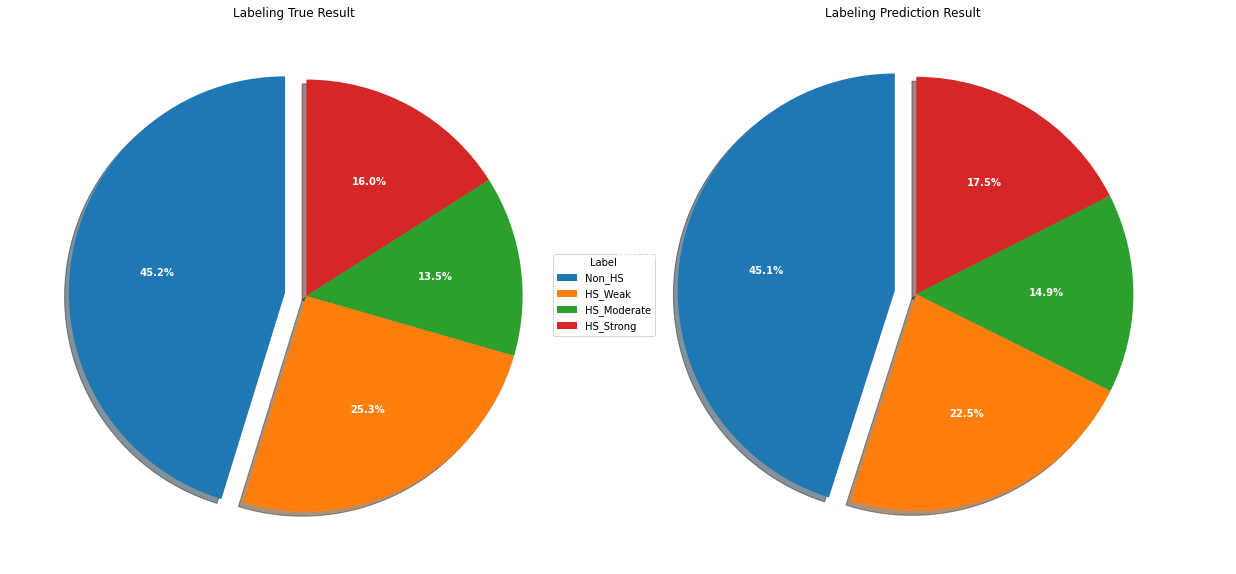

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw=dict(aspect="equal"))
labels = 'Non_HS', 'HS_Weak', 'HS_Moderate', 'HS_Strong'
labels = [x.split()[-1] for x in labels]

# true result
sizes = [amount_of_true_non_hs, amount_of_true_hs_weak, amount_of_true_hs_moderate, amount_of_true_hs_strong]
explode = (0.1, 0, 0, 0)

ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, textprops=dict(color="white", weight="bold"))
ax1.axis('equal')
ax1.set_title('Labeling True Result')

# prediction result
sizes = [amount_of_pred_non_hs, amount_of_pred_hs_weak, amount_of_pred_hs_moderate, amount_of_pred_hs_strong]
explode = (0.1, 0, 0, 0)

ax2.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, textprops=dict(color="white", weight="bold"))
ax2.axis('equal')
ax2.set_title('Labeling Prediction Result')

# set legend label
ax1.legend(
    labels, title='Label', loc="center left", bbox_to_anchor=(1, 0, 0.5, 1)
)

ax1.plot()
ax2.plot()

## 8.3 Test Fine-Tuned Model

In [90]:
text = 'kebahagiaan terbesarku adalah melihatmu bersama dengan dirinya'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text}')
print(f'Label: {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: kebahagiaan terbesarku adalah melihatmu bersama dengan dirinya
Label: Non_HS (99.397%)


In [91]:
text = 'tukang bully mati aja sana'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text}')
print(f'Label: {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: tukang bully mati aja sana
Label: HS_Weak (73.211%)


In [92]:
text = 'antek antek komunis mati sana'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text}')
print(f'Label: {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: antek antek komunis mati sana
Label: HS_Moderate (87.017%)


In [93]:
text = 'kemaren gue ga di ajak tai emang'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text}')
print(f'Label: {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: kemaren gue ga di ajak tai emang
Label: HS_Strong (74.551%)


In [94]:
print(logits)

tensor([[ 1.0096, -1.0400, -2.5017,  2.2317]], device='cuda:0')


In [95]:
print(torch.topk(logits, 1))

torch.return_types.topk(
values=tensor([[2.2317]], device='cuda:0'),
indices=tensor([[3]], device='cuda:0'))


# 9. Save Model

To save your model, download it to your local device or your Google Drive.

In [96]:
asfer
path = '/content/drive/MyDrive/multi-label-hate-speech-detection/models'

# check whether the specified path exists or not
# if not exists, path will be created
if not os.path.exists(path):
  # create output model path
  os.makedirs(path)

print("Saving model to %s" % path)

NameError: ignored

Save a trained model, configuration and tokenizer using `save_pretrained()`.
They can then be reloaded using `from_pretrained()`

In [ ]:
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(path)
tokenizer.save_pretrained(path)

In [ ]:
# save tokenizer
with open('/content/drive/MyDrive/multi-label-hate-speech-detection/models/tokenizer.pkl', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Let's check out the file sizes, out of curiosity.

In [ ]:
!ls -l --block-size=K /content/drive/MyDrive/multi-label-hate-speech-detection/models

# **Format Code**

**How to Use Black for Jupyter Formatter on Google Colab**

[Run only once, at startup]

*   Connect to your Drive
*   Install black for jupyter with `!pip install black[jupyter]`
*   Restart kernel

[Then]

*   Place your Jupyter Notebook file somewhere on your Drive
*   Anytime you want format your code run: `!black /content/drive/MyDrive/YOUR_PATH/YOUR_NOTEBOOK.ipynb`
*   Don't save your notebook, hit F5 to refresh the page
*   Voila! Now save!

[Reference from here](https://stackoverflow.com/questions/63076002/code-formatter-like-nb-black-for-google-colab)

In [ ]:
# run (uncomment) line below if you want to format your code with black formatter
# !black /content/drive/MyDrive/Skripsi/Code/multi-label-hate-speech-detection/src/multi_label_hs/preprocessing/text_preprocessing.ipynb